# RAG agent with Langgraph

https://github.com/langchain-ai/langgraph/blob/main/examples/rag/
의 코드를 일부 수정한 파일입니다.

## 아래에 주어진 코드가 나타내는 RAG 구조입니다. (현재 코드)

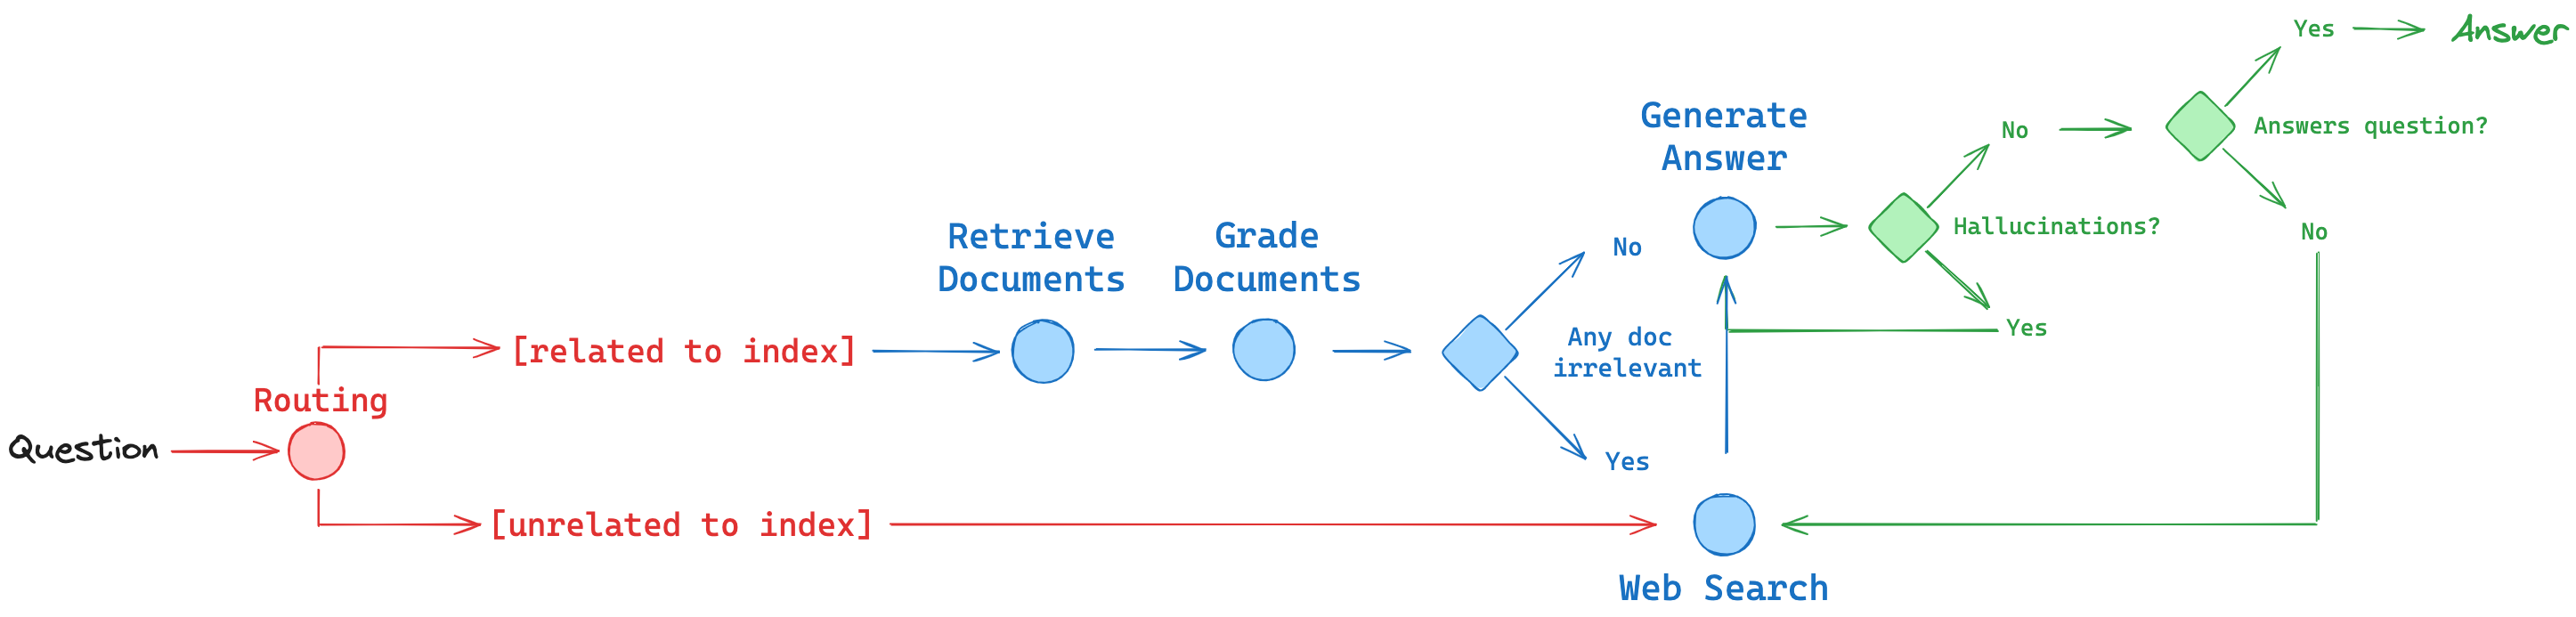


In [ ]:
import random

# 리스트에 모든 이름 저장
names = [
    "biber.baek", "iris.kang", "mogga.p", "philip.1", "sun.choi", "lukas.kdy",
    "mj.db", "levin.kitty", "adel.yang", "ruby.areum", "sophie.re", "jun.lee",
    "leah.han", "nacho.chili", "cosmo.kim", "joseph.jyoon", "zeno.park",
    "angus.bak", "jin.1115", "lauren.jang", "hannah.b", "yum.jung", "jenna.me",
    "dongdong.ju", "logan.1224", "alan.yu", "bruce.yoon", "marcus.min",
    "joey.51", "ed.ji", "mac.ss", "edgar.p", "finn.h", "keith.k", "harry.jo",
    "maui.yu", "jarry.ol"
]

# 무작위로 2명을 선택
random_selection = random.sample(names, 2)
random_selection

['logan.1224', 'biber.baek']

아래 3개 개념을 활용해서 간단한 RAG agent (agentic RAG) 를 구현합니다.

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question


## 코드를 일부 수정하여, 구현해야 하는 RAG 구조 그림입니다.

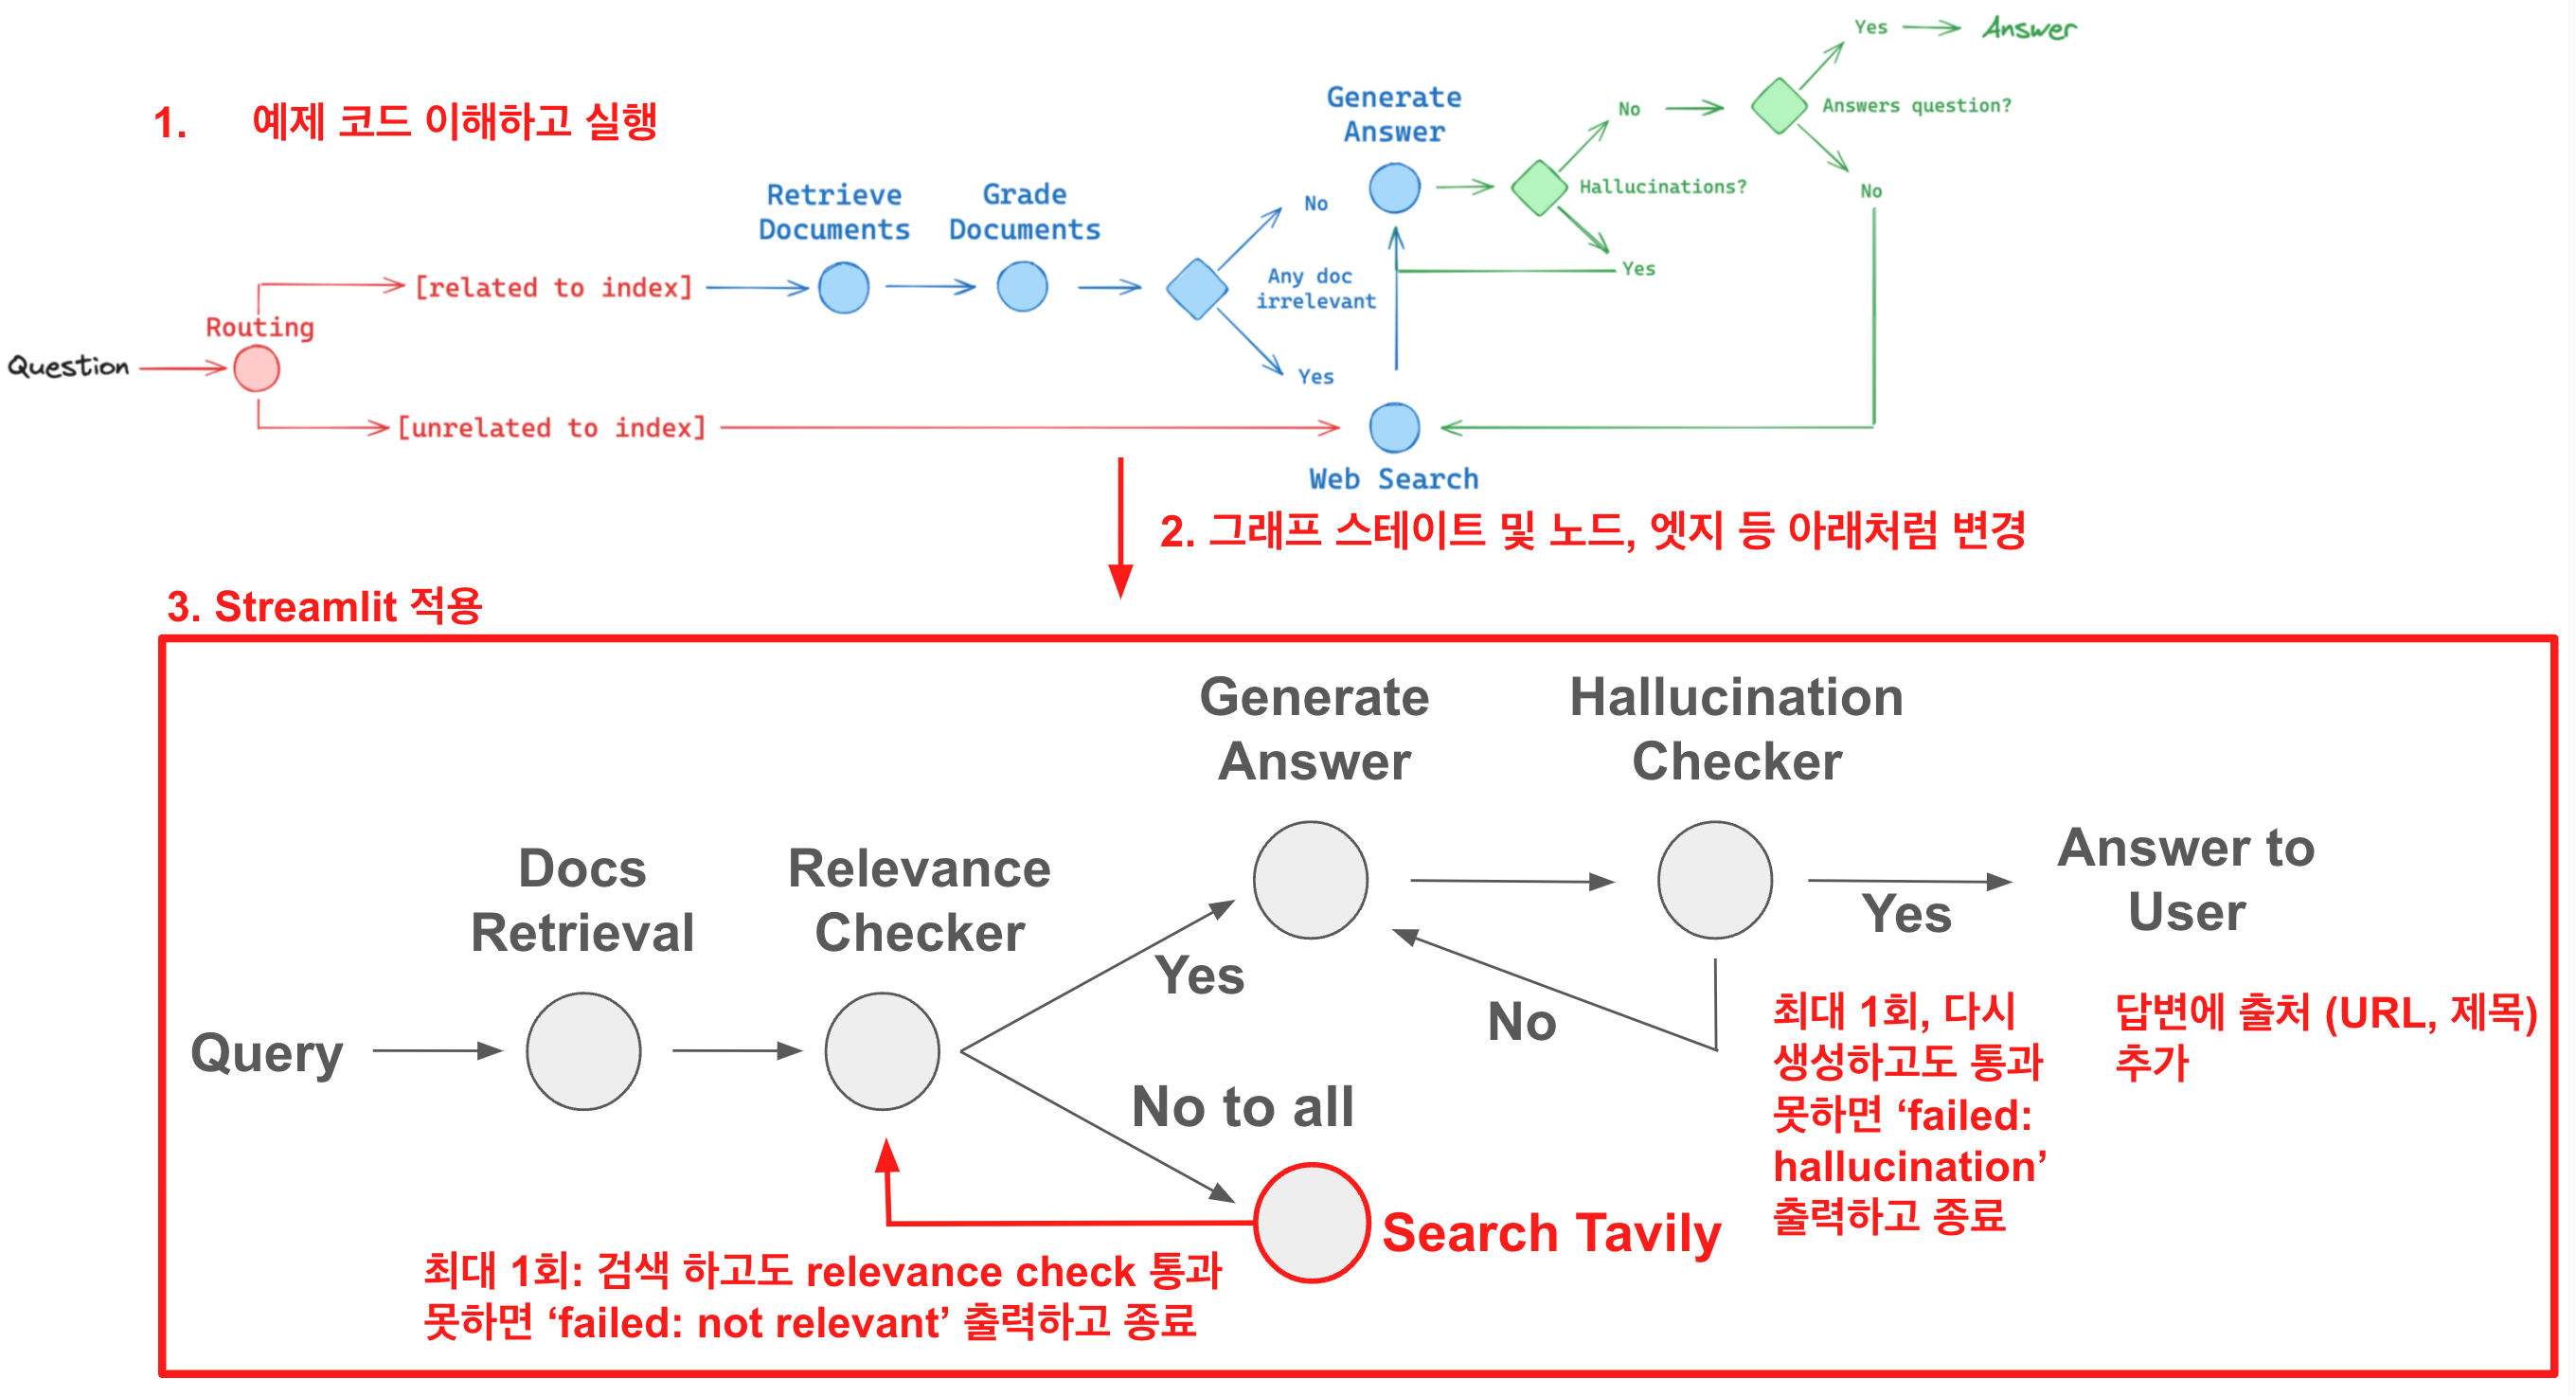


Answer 에는 출처 (vectorstore 에서 검색하는 경우는 source 값, Tavily 로 web search 하는 경우에는 url 값을 표시해주세요.

# 이번 RAG agent 실습에서는 LLM 으로 OpenAI 모델을 사용합니다.

In [ ]:
%%capture --no-stderr
%pip install langchain_community langchainhub chromadb langchain langgraph tavily-python langchain-text-splitters langchain_openai

## Relevance Check 후 모든 chunk 에 대해 no 라는 결과를 얻는다면, 검색을 합니다.
## 이 때, Tavily API 를 이용해 검색합니다.
## 사용 방법은 아래와 같습니다.

회원 가입 후 무료 Credit 받기 (up to 1000) API key at: https://tavily.com/

quickstart
- 아래 코드의 실행 결과를 확인해보세요
- response_context, response_qna 는 그냥 response 와 어떻게 다른지 확인해보세요.

참고: https://github.com/tavily-ai/tavily-python

In [ ]:
from getpass import getpass
from tavily import TavilyClient

# tavily = TavilyClient(api_key='api key')
tavily = TavilyClient(api_key=getpass())

response = tavily.search(query="Where does Messi play right now?", max_results=3)
context = [{"url": obj["url"], "content": obj["content"]} for obj in response['results']]

# You can easily get search result context based on any max tokens straight into your RAG.
# The response is a string of the context within the max_token limit.

response_context = tavily.get_search_context(query="Where does Messi play right now?", search_depth="advanced", max_tokens=500)

# You can also get a simple answer to a question including relevant sources all with a simple function call:
# You can use it for baseline
response_qna = tavily.qna_search(query="Where does Messi play right now?")


··········


In [ ]:
response

{'query': 'Where does Messi play right now?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Lionel_Messi',
   'title': 'Lionel Messi - Wikipedia',
   'content': "He joined MLS club Inter Miami in July 2023. An Argentine international, Messi is the national team's all-time leading goalscorer and most-capped player.",
   'score': 0.68748367,
   'raw_content': None},
  {'url': 'https://www.transfermarkt.us/lionel-messi/profil/spieler/28003',
   'title': 'Lionel Messi - Player profile 2025 | Transfermarkt',
   'content': 'Lionel Messi, 38, from Argentina ➤ Inter Miami CF, since 2023 ➤ Right Winger ➤ Market value: €18.00m ➤ * Jun 24, 1987 in Rosario, Argentina.',
   'score': 0.65861565,
   'raw_content': None},
  {'url': 'https://www.intermiamicf.com/players/lionel-messi/',
   'title': 'Lionel Messi | Inter Miami CF',
   'content': '#10 • Forward • Inter Miami CF. Senior Name Lionel Messi. Height 5\' 7". Weight 148 lbs. Dat

In [ ]:
response["query"]

'Where does Messi play right now?'

In [ ]:
len(response["results"])

3

# RAG with langgraph

In [ ]:
from langchain_openai import ChatOpenAI
from getpass import getpass
import os

# os.environ['OPENAI_API_KEY'] = 'api key'
os.environ['OPENAI_API_KEY'] = getpass()

llm = ChatOpenAI(model="gpt-4o-mini", temperature = 0)

··········


### Tracing (optional)

In [ ]:
# import os

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = "<your-api-key>"

In [ ]:
%%capture --no-stdout
### Index

from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
)
retriever = vectorstore.as_retriever()

In [ ]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7fb5358819d0>, search_kwargs={})

In [ ]:
%%capture --no-stdout
### Router
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are an expert at routing a user question to a vectorstore or web search.
Use the vectorstore for questions on agent, LLM agents, prompt engineering, and adversarial attacks.
You do not need to be stringent with the keywords in the question related to these topics.
Otherwise, use web-search. Give a binary choice 'web_search' or 'vectorstore' based on the question.
Return the a JSON with a single key 'datasource' and no premable or explanation. Question to route"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}"),
    ]
)

question_router = prompt | llm | JsonOutputParser()

# question = "llm agent memory"
question = "What is prompt?"
docs = retriever.get_relevant_documents(question)
print(question_router.invoke({"question": question}))

{'datasource': 'web_search'}


In [ ]:
docs[0].metadata

{'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.',
 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
 'title': "Prompt Engineering | Lil'Log",
 'language': 'en'}

In [ ]:
docs[0].page_content

'Automatic Prompt Design#\nPrompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore we can treat them as trainable parameters and optimize them directly on the embedding space via gradient descent, such as AutoPrompt (Shin et al., 2020, Prefix-Tuning (Li & Liang (2021)), P-tuning (Liu et al. 2021) and Prompt-Tuning (Lester et al. 2021). This section in my “Controllable Neural Text Generation” post has a good coverage of them. The trend from AutoPrompt to Prompt-Tuning is that the setup gets gradually simplified.\nAPE (Automatic Prompt Engineer; Zhou et al. 2022) is a method to search over a pool of model-generated instruction candidates and then filters the candidate set according to a chosen score function to ultimately choose the best candidate with highest score.\n\n\nPrompt LLM to generate instruction candidates based on a small set of demonstrations in the form of input-output pairs. E.g. {{Given desired input-output pai

In [ ]:
print(docs[0].page_content)

Automatic Prompt Design#
Prompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore we can treat them as trainable parameters and optimize them directly on the embedding space via gradient descent, such as AutoPrompt (Shin et al., 2020, Prefix-Tuning (Li & Liang (2021)), P-tuning (Liu et al. 2021) and Prompt-Tuning (Lester et al. 2021). This section in my “Controllable Neural Text Generation” post has a good coverage of them. The trend from AutoPrompt to Prompt-Tuning is that the setup gets gradually simplified.
APE (Automatic Prompt Engineer; Zhou et al. 2022) is a method to search over a pool of model-generated instruction candidates and then filters the candidate set according to a chosen score function to ultimately choose the best candidate with highest score.


Prompt LLM to generate instruction candidates based on a small set of demonstrations in the form of input-output pairs. E.g. {{Given desired input-output pairs}}\n

In [ ]:
### Retrieval Grader
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are a grader assessing relevance
    of a retrieved document to a user question. If the document contains keywords related to the user question,
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n document: {document} "),
    ]
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "What is prompt?"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [ ]:
doc_txt

'Automatic Prompt Design#\nPrompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore we can treat them as trainable parameters and optimize them directly on the embedding space via gradient descent, such as AutoPrompt (Shin et al., 2020, Prefix-Tuning (Li & Liang (2021)), P-tuning (Liu et al. 2021) and Prompt-Tuning (Lester et al. 2021). This section in my “Controllable Neural Text Generation” post has a good coverage of them. The trend from AutoPrompt to Prompt-Tuning is that the setup gets gradually simplified.\nAPE (Automatic Prompt Engineer; Zhou et al. 2022) is a method to search over a pool of model-generated instruction candidates and then filters the candidate set according to a chosen score function to ultimately choose the best candidate with highest score.\n\n\nPrompt LLM to generate instruction candidates based on a small set of demonstrations in the form of input-output pairs. E.g. {{Given desired input-output pai

In [ ]:
### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n context: {context} "),
    ]
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "What is prompt?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

A prompt is a sequence of tokens designed to increase the likelihood of generating a desired output from a language model. It serves as a way to communicate with the model without altering its weights, focusing on steering its behavior for specific outcomes. Prompt engineering involves experimenting with different prompts to optimize their effectiveness across various models.


In [ ]:
print("\n".join(generation.split(".")))

A prompt is a sequence of tokens designed to increase the likelihood of generating a desired output from a language model
 It serves as a way to communicate with the model without altering its weights, focusing on steering its behavior for specific outcomes
 Prompt engineering involves experimenting with different prompts to optimize their effectiveness across various models



In [ ]:
### Hallucination Grader

system = """You are a grader assessing whether
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
    single key 'score' and no preamble or explanation."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "documents: {documents}\n\n answer: {generation} "),
    ]
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [ ]:
### Answer Grader


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)


# Prompt
system = """You are a grader assessing whether an
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "question: {question}\n\n answer: {generation} "),
    ]
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

We'll implement these as a control flow in LangGraph.

An extension of langchain aimed at building robust and stateful multi-actor applications with LLMs by modeling steps as edges and nodes in a graph.

Exposes high level interfaces for creating common types of agents, as well as a low-level API for composing custom flows.

https://python.langchain.com/v0.2/docs/concepts/#langgraph

In [ ]:
from pprint import pprint
from typing import List

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph

### State


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


### Nodes

def retrieve(state) -> dict:
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print(question)
    print(documents)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state) -> dict:
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def web_search(state) -> dict:
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    print(state)
    question = state["question"]
    documents = None
    if "documents" in state:
      documents = state["documents"]

    # Web search
    docs = tavily.search(query=question)['results']
#    [{'title': 'Where will Lionel Messi play in 2024? Cities, stadiums Inter Miami ...', 'url': 'https://www.sportingnews.com/us/soccer/news/where-lionel-messi-play-2024-inter-miami-cities-road-schedule/23334c5768cebee9021e71d0', 'content': "Here is how Inter Miami's road schedule will look for the coming regular season:\nInter Miami home stadium for 2024 MLS season\nFor their home matches through the 2024 campaign, Inter Miami will once again play at\xa0DRV PNK Stadium in Fort Lauderdale, Florida.\n Cities, stadiums Inter Miami visit on road MLS schedule for new season\nWith Lionel Messi set to embark on his first full season with Inter Miami, fans across the United States will be clamoring to see when the Argentine superstar will visit their city in 2024.\n MLS Season Pass is separate from Apple TV+, meaning those with Apple TV+ would still need an MLS Season Pass subscription to access the complete slate of games, while those without Apple TV+ can still sign up for MLS Season Pass without needing a full Apple TV+ subscription.\n SUBSCRIBE TO MLS SEASON PASS NOW\nApple TV is the official home of the MLS regular season and playoffs, with every match for every team available to stream around the world with no blackouts. How to watch Inter Miami in 2024 MLS season\nLast season, Major League Soccer kicked off a 10-year broadcast rights deal with Apple that sees every single match for the next decade streamed exclusively on Apple's streaming platform.\n", 'score': 0.98612, 'raw_content': None}, {'title': 'Is Lionel Messi playing today? Status for next Inter Miami game in 2024 ...', 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-playing-today-inter-miami-game-2024/129c2c378fee4d1f0102aa9d', 'content': '* Lionel Messi did not participate. Inter Miami schedule for Leagues Cup. The 2024 Leagues Cup is scheduled to begin on July 26, running for a month while the MLS season pauses play.. The final ...', 'score': 0.98209, 'raw_content': None}, {'title': 'Lionel Messi joins Inter Miami: Schedule, MLS tickets to see him play', 'url': 'https://www.usatoday.com/story/sports/mls/2023/06/07/lionel-messi-inter-miami-schedule-tickets/70299298007/', 'content': 'Lionel Messi joins Inter Miami: Full schedule, MLS tickets to see Messi play in US\nLionel Messi\xa0is taking his talents to South Beach.\nMessi,\xa0the 2022 World Cup champion, announced on Wednesday that he will join Major League Soccer\'s Inter Miami CF, a pro soccer club owned by David Beckham, after exiting Ligue 1\'s Paris Saint-Germain following two seasons.\n Tickets to Inter Miami\'s game on June 10 range from $40-$55, but the price tag to see Inter Miami play LigaMX\'s Cruz Azul on July 21 soared to $495 in anticipation of what\'s expected to be Messi\'s first home game, TicketSmarter CEO Jeff Goodman told USA TODAY Sports.\n Each team will play a minimum of two games in the group stage, similar to the World Cup format, with the possibility of more games if the team advances to the knockout rounds.\n "\nAccording to Goodman, nearly 2,000 Inter Miami tickets sold on TicketSmarter the day of Messi\'s announcement Wednesday, compared to under 50 tickets being sold on the platform over the weekend.\n If the Barcelona thing didn\'t work out, I wanted to leave Europe, get out of the spotlight and think more of my family.', 'score': 0.97895, 'raw_content': None}, {'title': "Lionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues ...", 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-2023-inter-miami-schedule/d3buao2mhfp7uculkdz3nsc4', 'content': "MORE:\xa0Trophies that Lionel Messi can win with Inter Miami in USA\nLeagues Cup\nIn his first three matches with Inter Miami, Lionel Messi lifted the club into the Leagues Cup Round of 16 thanks to three straight home wins that he helped orchestrate.\n Edition\nLionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues Cup and U.S. Open Cup\nLionel Messi is taking North America by storm after scoring in his first three matches for his new club Inter Miami CF.\n MORE: Messi's Miami apartment | Messi's wife & family | Messi's net worth\nLionel Messi, Inter Miami 2023 schedule\nBelow are the remaining games for Inter Miami that Messi will be a part of. MLS\nAfter the Leagues Cup is out of the way, Inter Miami will have 12 MLS matchdays left in a bid to reach the MLS Cup playoffs.\n Inter Miami can still make MLS playoffs\xa0with Lionel Messi\nU.S. Open Cup\nInter Miami reached the semifinal of the competition before Messi and friends joined.", 'score': 0.97298, 'raw_content': None}, {'title': 'Messi, Argentina to play in Chicago, DC before Copa America: More info', 'url': 'https://www.usatoday.com/story/sports/soccer/2024/05/20/messi-argentina-to-play-in-chicago-dc-before-copa-america-more-info/73770204007/', 'content': "1:00. World Cup champion Lionel Messi will participate in two Argentina friendlies early next month before Copa América begins June 20. Messi was officially named to Argentina's 29-man roster ...", 'score': 0.97096, 'raw_content': None}]
#
#

    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}


### Edges


def route_question(state) -> str:
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state) -> str:
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


### Conditional edge


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae

### Graph Build

In [ ]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [ ]:
# Compile
app = workflow.compile()

# Test

inputs = {"question": "What is prompt?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
What is prompt?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE---
What is prompt?
[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model wei

In [ ]:
# 여러 질문을 수행할거라면 document 등 state초기화 필요
document = None

In [ ]:
@Nodes

# Retrieve Documents
def retrieve(state) -> dict:
	  ...
	  return {"documents": documents, "question": question}


# ...
def generate(state) -> dict:
	  ...
    return {"documents": documents, "question": question, "generation": generation}


# Grade Documents
def grade_documents(state) -> dict:
	  ...
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


# Web Search
def web_search(state) -> dict:
	  ...
    return {"documents": documents, "question": question}


---

@Edges

# related to index, unrelated to index
def route_question(state) -> str:
	  ...
	  return "websearch"
    return "vectorstore"


# Any doc irrelevant
def decide_to_generate(state) -> str:
	  ...
    return "websearch"
    return "generate"


---

@Conditional Edge

# Hallucinations? Answers question?
def grade_generation_v_documents_and_question(state) -> str:
	  ...
    return "useful"
    return "not useful"
    return "not supported"


참고 LangSmith Trace:

https://smith.langchain.com/public/8d449b67-6bc4-4ecf-9153-759cd21df24f/r

In [159]:
from pprint import pprint

# Compile
app = workflow.compile()
inputs = {"question": "Where does Messi play right now?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Where does Messi play right now?
{'datasource': 'web_search'}
web_search
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
{'question': 'Where does Messi play right now?'}
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Lionel Messi currently plays for Inter Miami CF in Major League Soccer '
 '(MLS), having joined the club in July 2023.')


## Streamlit 활용해 GUI 제공

RAG agent 코드에 Streamlit 붙인 예시 코드: https://drive.google.com/file/d/1VPQkv43GCN3mlNI9R8xrbdj6ImEhiBCg/view?usp=drive_link

In [ ]:
%%capture --no-stderr
%pip install streamlit pyngrok gpt4all

In [ ]:
%%writefile app.py
import streamlit as st
from tavily import TavilyClient
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, StateGraph
from typing import List
from typing_extensions import TypedDict
from langchain_core.documents import Document

tavily = TavilyClient(api_key="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")

st.set_page_config(
    page_title="Research Assistant",
    page_icon=":orange_heart:",
)


class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]


def main():
    # 모델 선택
    llm_model = st.sidebar.selectbox(
        "Select Model",
        options=[
            "llama3",
        ],
    )

    urls = [
        "https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
        "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    ]

    # 웹 페이지 로드 및 문서 분할
    docs = [WebBaseLoader(url).load() for url in urls]
    docs_list = [item for sublist in docs for item in sublist]

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(docs_list)

    # 벡터 저장소 생성
    vectorstore = Chroma.from_documents(
        documents=doc_splits,
        collection_name="rag-chroma",
        embedding=GPT4AllEmbeddings(model_name="all-MiniLM-L6-v2.gguf2.f16.gguf"),
    )
    retriever = vectorstore.as_retriever()

    # RAG 에이전트 노드 및 엣지 정의
    def retrieve(state):
        print("---RETRIEVE---")
        question = state["question"]
        documents = retriever.invoke(question)
        return {"documents": documents, "question": question}

    def generate(state):
        print("---GENERATE---")
        question = state["question"]
        documents = state["documents"]
        generation = rag_chain.invoke({"context": documents, "question": question})
        return {"documents": documents, "question": question, "generation": generation}

    def grade_documents(state):
        print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
        question = state["question"]
        documents = state["documents"]
        filtered_docs = []
        web_search = "No"
        for d in documents:
            score = retrieval_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score["score"]
            if grade.lower() == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
                web_search = "Yes"
                continue
        return {
            "documents": filtered_docs,
            "question": question,
            "web_search": web_search,
        }

    def web_search(state):
        print("---WEB SEARCH---")
        question = state["question"]
        documents = state["documents"]
        docs = tavily.search(query=question)["results"]
        web_results = "\n".join([d["content"] for d in docs])
        web_results = Document(page_content=web_results)
        if documents is not None:
            documents.append(web_results)
        else:
            documents = [web_results]
        return {"documents": documents, "question": question}

    def route_question(state):
        print("---ROUTE QUESTION---")
        question = state["question"]
        print(question)
        source = question_router.invoke({"question": question})
        print(source)
        print(source["datasource"])
        if source["datasource"] == "web_search":
            print("---ROUTE QUESTION TO WEB SEARCH---")
            return "websearch"
        elif source["datasource"] == "vectorstore":
            print("---ROUTE QUESTION TO RAG---")
            return "vectorstore"

    def decide_to_generate(state):
        print("---ASSESS GRADED DOCUMENTS---")
        state["question"]
        web_search = state["web_search"]
        state["documents"]

        if web_search == "Yes":
            print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
            )
            return "websearch"
        else:
            print("---DECISION: GENERATE---")
            return "generate"

    def grade_generation_v_documents_and_question(state):
        print("---CHECK HALLUCINATIONS---")
        question = state["question"]
        documents = state["documents"]
        generation = state["generation"]

        score = hallucination_grader.invoke(
            {"documents": documents, "generation": generation}
        )
        grade = score["score"]

        if grade == "yes":
            print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
            print("---GRADE GENERATION vs QUESTION---")
            score = answer_grader.invoke(
                {"question": question, "generation": generation}
            )
            grade = score["score"]
            if grade == "yes":
                print("---DECISION: GENERATION ADDRESSES QUESTION---")
                return "useful"
            else:
                print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
                return "not useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
            return "not supported"

    # RAG 에이전트 그래프 구성
    workflow = StateGraph(GraphState)
    workflow.add_node("websearch", web_search)
    workflow.add_node("retrieve", retrieve)
    workflow.add_node("grade_documents", grade_documents)
    workflow.add_node("generate", generate)

    workflow.set_conditional_entry_point(
        route_question,
        {
            "websearch": "websearch",
            "vectorstore": "retrieve",
        },
    )

    workflow.add_edge("retrieve", "grade_documents")
    workflow.add_conditional_edges(
        "grade_documents",
        decide_to_generate,
        {
            "websearch": "websearch",
            "generate": "generate",
        },
    )
    workflow.add_edge("websearch", "generate")
    workflow.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_question,
        {
            "not supported": "generate",
            "useful": END,
            "not useful": "websearch",
        },
    )

    app = workflow.compile()

    # rag_chain 정의
    llm = ChatOllama(model=llm_model, temperature=0)
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
        Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
        Question: {question}
        Context: {context}
        Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question", "context"],
    )
    rag_chain = prompt | llm | StrOutputParser()

    # retrieval_grader, hallucination_grader, answer_grader 정의
    llm = ChatOllama(model=llm_model, format="json", temperature=0)

    retrieval_grader_prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
        of a retrieved document to a user question. If the document contains keywords related to the user question,
        grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
         <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here is the retrieved document: \n\n {document} \n\n
        Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
        """,
        input_variables=["question", "document"],
    )
    retrieval_grader = retrieval_grader_prompt | llm | JsonOutputParser()

    hallucination_grader_prompt = PromptTemplate(
        template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
        an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate
        whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
        single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here are the facts:
        \n ------- \n
        {documents}
        \n ------- \n
        Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["generation", "documents"],
    )
    hallucination_grader = hallucination_grader_prompt | llm | JsonOutputParser()

    answer_grader_prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
        answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is
        useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
         <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
        \n ------- \n
        {generation}
        \n ------- \n
        Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["generation", "question"],
    )
    answer_grader = answer_grader_prompt | llm | JsonOutputParser()

    question_router_prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents,
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
    no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question"],
    )
    question_router = question_router_prompt | llm | JsonOutputParser()

    # ----------------------------------------------------------------------
    # Streamlit 앱 UI
    st.title("Research Assistant powered by OpenAI")

    input_topic = st.text_input(
        ":female-scientist: Enter a topic",
        value="Superfast Llama 3 inference on Groq Cloud",
    )

    generate_report = st.button("Generate Report")

    if generate_report:
        with st.spinner("Generating Report"):
            inputs = {"question": input_topic}
            for output in app.stream(inputs):
                for key, value in output.items():
                    print(f"Finished running: {key}:")
            final_report = value["generation"]
            st.markdown(final_report)

    st.sidebar.markdown("---")
    if st.sidebar.button("Restart"):
        st.session_state.clear()
        st.experimental_rerun()


main()

Overwriting app.py


In [ ]:
from pyngrok import conf, ngrok
from getpass import getpass

conf.get_default().auth_token = getpass()
public_url = ngrok.connect(8501)
public_url

··········


<NgrokTunnel: "https://ea7abe74944d.ngrok-free.app" -> "http://localhost:8501">

In [ ]:
!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.66.86.205:8501

USER_AGENT environment variable not set, consider setting it to identify your requests.
Downloading: 100% 45.9M/45.9M [00:00<00:00, 123MiB/s]
Verifying: 100% 45.9M/45.9M [00:00<00:00, 626MiB/s]
Failed to load libllamamodel-mainline-cuda.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
Failed to load libllamamodel-mainline-cuda-avxonly.so: dlopen: libcudart.so.11.0: cannot open shared object file: No such file or directory
/content/app.py:208: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import Chat

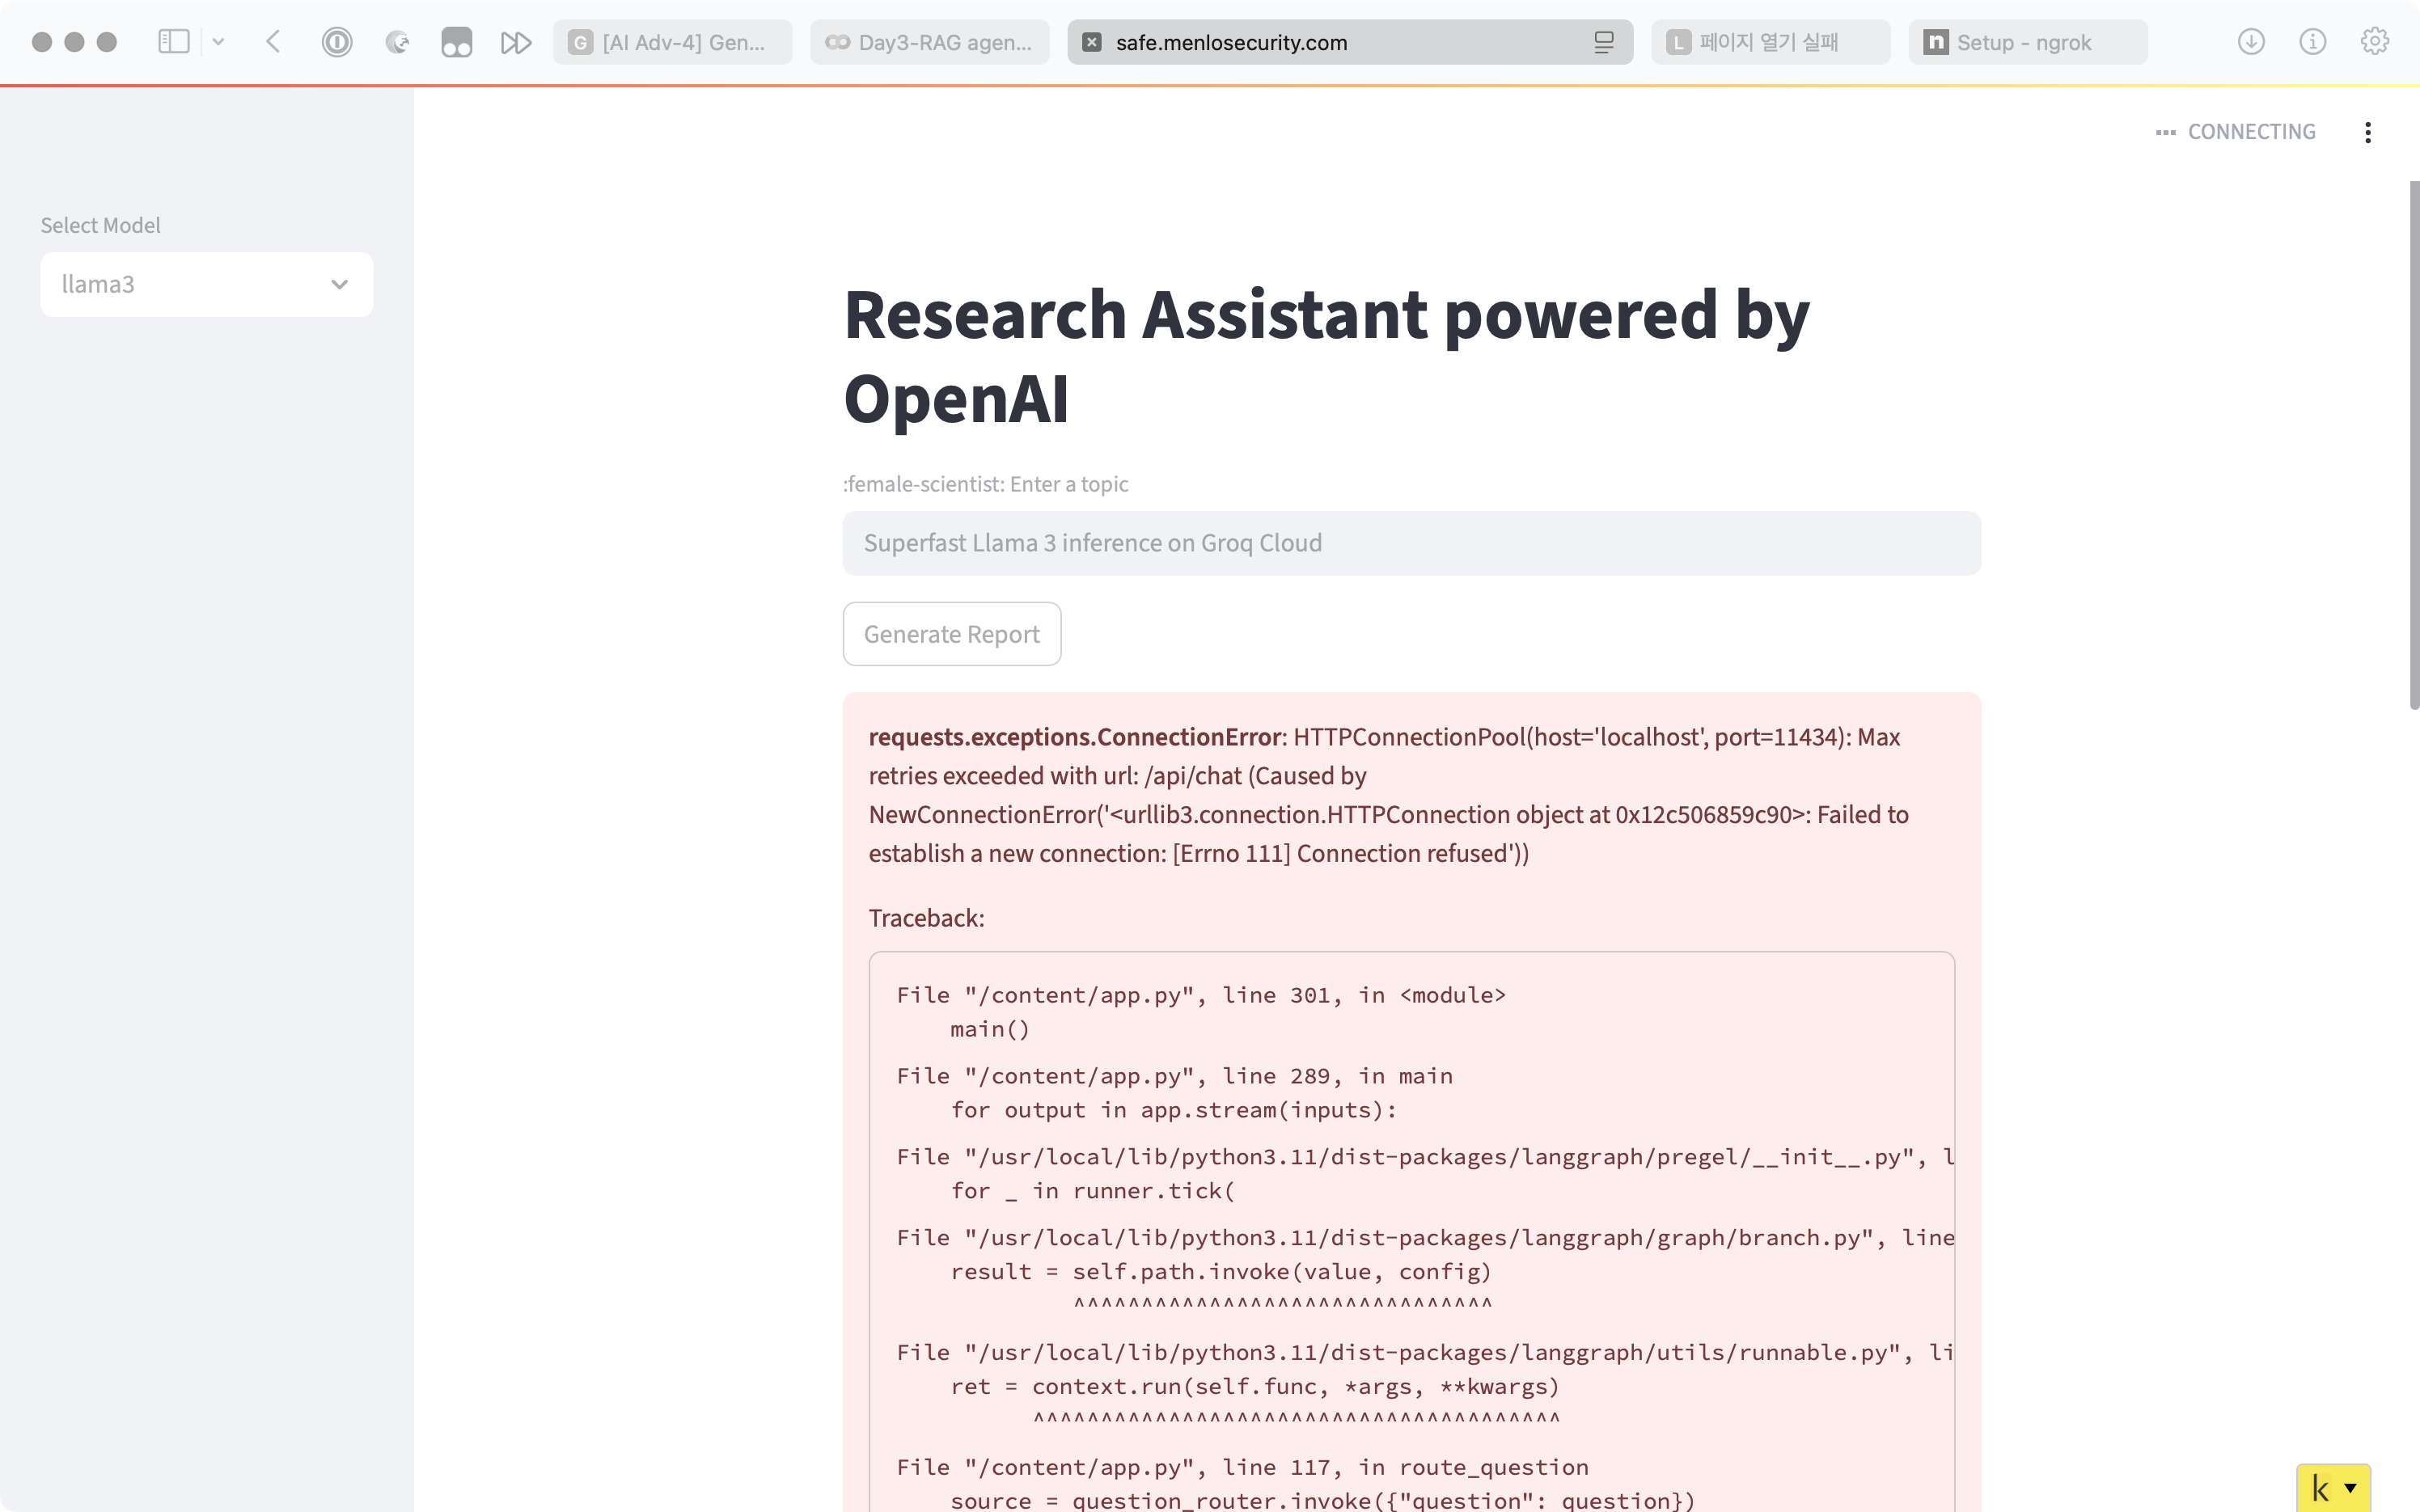

# # 구현


## # v2

2. 그래프 스테이트 및 노드, 엣지 등 아래처럼 변경  
(함수 동작방식은 변경하지 않음)

In [72]:
query = "What is prompt?"

In [67]:
# Docs Retrieval
## Retrieve Documents
retrieve

<function __main__.retrieve(state) -> dict>

In [69]:
# Relevance Checker
## Any doc irrelevant
decide_to_generate

<function __main__.decide_to_generate(state) -> str>

In [70]:
# Generate Answer
## ...
generate

<function __main__.generate(state)>

In [71]:
# Hallucination Checker
## Hallucinations? Answers question?
grade_generation_v_documents_and_question

<function __main__.grade_generation_v_documents_and_question(state)>

In [162]:
# Node
## Docs Retrieval

def retrieve_v2(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print(question)
    print(documents)
    return {"documents": documents, "question": question, "web_search": "notyet"}

In [154]:
# Conditional Edge
## Relevance Checker

decide_to_generate_v2 = decide_to_generate

In [153]:
# Node
## Generate Answer

generate_v2 = generate

In [151]:
# Node
## Search Tavily

web_search_v2 = web_search

In [152]:
# Conditional Edge
## Hallucination Checker

grade_generation_v_documents_and_question_v2 = grade_generation_v_documents_and_question

In [163]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict


class GraphState_v2(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]


workflow_v2 = StateGraph(GraphState_v2)

# Define the nodes
workflow_v2.add_node("retrieve", retrieve_v2)     # Docs Retrieval
workflow_v2.add_node("generate", generate_v2)     # Generate Answer
workflow_v2.add_node("websearch", web_search_v2)  # Search Tavily

# Build graph
workflow_v2.set_entry_point("retrieve")
workflow_v2.add_conditional_edges(
    "retrieve",
    decide_to_generate_v2,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow_v2.add_conditional_edges(
    "websearch",
    decide_to_generate_v2,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow_v2.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question_v2,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [164]:
# Compile
app_v2 = workflow_v2.compile()

# Test
query = "What is prompt?"
inputs = {"question": query}
for output in app_v2.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
What is prompt?
[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'language': 'en', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.'}, page_content='Automatic Prompt Design#\nPrompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore

## # v3

3. 그래프 스테이트 및 노드, 엣지 등 아래처럼 변경  
(함수 동작방식 또한 변경)

In [257]:
class GraphState_v3(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
        web_search_irrelevant_count: Retry count
        generate_hallucination_count: Retry count
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]
    web_search_count: int = 0
    generation_count: int = 0

In [258]:
# Node
## Docs Retrieval

def retrieve_v3(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print(question)
    print(documents)
    return {"documents": documents,
            "question": question,
            "web_search": "notyet",
            "web_search_count": 0,
            "generation_count": 0}

In [259]:
# Conditional Edge
## Relevance Checker

def decide_to_generate_v3(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]
    web_search_count = state["web_search_count"]
    generation_count = state["generation_count"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )

        if web_search_count == 2:
            print("---FAILED: NOT RELEVANT---")
            return "irrelevant"

        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [260]:
# Node
## Generate Answer

def generate_v3(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    web_search_count = state["web_search_count"]
    generation_count = state["generation_count"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents,
            "question": question,
            "generation": generation,
            "web_search_count": web_search_count,
            "generation_count": generation_count + 1}

In [261]:
# Node
## Search Tavily

def web_search_v3(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    print(state)
    question = state["question"]
    documents = None
    if "documents" in state:
      documents = state["documents"]
    web_search_count = state["web_search_count"]
    generation_count = state["generation_count"]

    # Web search
    docs = tavily.search(query=question)['results']
#    [{'title': 'Where will Lionel Messi play in 2024? Cities, stadiums Inter Miami ...', 'url': 'https://www.sportingnews.com/us/soccer/news/where-lionel-messi-play-2024-inter-miami-cities-road-schedule/23334c5768cebee9021e71d0', 'content': "Here is how Inter Miami's road schedule will look for the coming regular season:\nInter Miami home stadium for 2024 MLS season\nFor their home matches through the 2024 campaign, Inter Miami will once again play at\xa0DRV PNK Stadium in Fort Lauderdale, Florida.\n Cities, stadiums Inter Miami visit on road MLS schedule for new season\nWith Lionel Messi set to embark on his first full season with Inter Miami, fans across the United States will be clamoring to see when the Argentine superstar will visit their city in 2024.\n MLS Season Pass is separate from Apple TV+, meaning those with Apple TV+ would still need an MLS Season Pass subscription to access the complete slate of games, while those without Apple TV+ can still sign up for MLS Season Pass without needing a full Apple TV+ subscription.\n SUBSCRIBE TO MLS SEASON PASS NOW\nApple TV is the official home of the MLS regular season and playoffs, with every match for every team available to stream around the world with no blackouts. How to watch Inter Miami in 2024 MLS season\nLast season, Major League Soccer kicked off a 10-year broadcast rights deal with Apple that sees every single match for the next decade streamed exclusively on Apple's streaming platform.\n", 'score': 0.98612, 'raw_content': None}, {'title': 'Is Lionel Messi playing today? Status for next Inter Miami game in 2024 ...', 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-playing-today-inter-miami-game-2024/129c2c378fee4d1f0102aa9d', 'content': '* Lionel Messi did not participate. Inter Miami schedule for Leagues Cup. The 2024 Leagues Cup is scheduled to begin on July 26, running for a month while the MLS season pauses play.. The final ...', 'score': 0.98209, 'raw_content': None}, {'title': 'Lionel Messi joins Inter Miami: Schedule, MLS tickets to see him play', 'url': 'https://www.usatoday.com/story/sports/mls/2023/06/07/lionel-messi-inter-miami-schedule-tickets/70299298007/', 'content': 'Lionel Messi joins Inter Miami: Full schedule, MLS tickets to see Messi play in US\nLionel Messi\xa0is taking his talents to South Beach.\nMessi,\xa0the 2022 World Cup champion, announced on Wednesday that he will join Major League Soccer\'s Inter Miami CF, a pro soccer club owned by David Beckham, after exiting Ligue 1\'s Paris Saint-Germain following two seasons.\n Tickets to Inter Miami\'s game on June 10 range from $40-$55, but the price tag to see Inter Miami play LigaMX\'s Cruz Azul on July 21 soared to $495 in anticipation of what\'s expected to be Messi\'s first home game, TicketSmarter CEO Jeff Goodman told USA TODAY Sports.\n Each team will play a minimum of two games in the group stage, similar to the World Cup format, with the possibility of more games if the team advances to the knockout rounds.\n "\nAccording to Goodman, nearly 2,000 Inter Miami tickets sold on TicketSmarter the day of Messi\'s announcement Wednesday, compared to under 50 tickets being sold on the platform over the weekend.\n If the Barcelona thing didn\'t work out, I wanted to leave Europe, get out of the spotlight and think more of my family.', 'score': 0.97895, 'raw_content': None}, {'title': "Lionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues ...", 'url': 'https://www.sportingnews.com/us/soccer/news/lionel-messi-2023-inter-miami-schedule/d3buao2mhfp7uculkdz3nsc4', 'content': "MORE:\xa0Trophies that Lionel Messi can win with Inter Miami in USA\nLeagues Cup\nIn his first three matches with Inter Miami, Lionel Messi lifted the club into the Leagues Cup Round of 16 thanks to three straight home wins that he helped orchestrate.\n Edition\nLionel Messi's 2023 Inter Miami schedule: Every match in MLS, Leagues Cup and U.S. Open Cup\nLionel Messi is taking North America by storm after scoring in his first three matches for his new club Inter Miami CF.\n MORE: Messi's Miami apartment | Messi's wife & family | Messi's net worth\nLionel Messi, Inter Miami 2023 schedule\nBelow are the remaining games for Inter Miami that Messi will be a part of. MLS\nAfter the Leagues Cup is out of the way, Inter Miami will have 12 MLS matchdays left in a bid to reach the MLS Cup playoffs.\n Inter Miami can still make MLS playoffs\xa0with Lionel Messi\nU.S. Open Cup\nInter Miami reached the semifinal of the competition before Messi and friends joined.", 'score': 0.97298, 'raw_content': None}, {'title': 'Messi, Argentina to play in Chicago, DC before Copa America: More info', 'url': 'https://www.usatoday.com/story/sports/soccer/2024/05/20/messi-argentina-to-play-in-chicago-dc-before-copa-america-more-info/73770204007/', 'content': "1:00. World Cup champion Lionel Messi will participate in two Argentina friendlies early next month before Copa América begins June 20. Messi was officially named to Argentina's 29-man roster ...", 'score': 0.97096, 'raw_content': None}]
#
#

    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents,
            "question": question,
            "web_search_count": web_search_count + 1,
            "generation_count": generation_count}

In [262]:
# Conditional Edge
## Hallucination Checker

def grade_generation_v_documents_and_question_v3(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    web_search_count = state["web_search_count"]
    generation_count = state["generation_count"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")

        if generation_count == 2:
            print("---FAILED: HALLUCINATION---")
            return "hallucination"

        return "not supported"

In [263]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict


workflow_v3 = StateGraph(GraphState_v3)

# Define the nodes
workflow_v3.add_node("retrieve", retrieve_v3)     # Docs Retrieval
workflow_v3.add_node("generate", generate_v3)     # Generate Answer
workflow_v3.add_node("websearch", web_search_v3)  # Search Tavily

# Build graph
workflow_v3.set_entry_point("retrieve")
workflow_v3.add_conditional_edges(
    "retrieve",
    decide_to_generate_v3,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow_v3.add_conditional_edges(
    "websearch",
    decide_to_generate_v3,
    {
        "websearch": "websearch",
        "generate": "generate",
        "irrelevant": END
    },
)
workflow_v3.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question_v3,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "hallucination": END
    },
)

In [264]:
# Compile
app_v3 = workflow_v3.compile()

In [265]:
# Test_1
document = None
query = "What is prompt?"
inputs = {"question": query}
try:
    for output in app_v3.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
except:
    pass
print("\n\n---RESULT---")
print("\n".join(value["generation"].split(".")))
print("\n".join(list(set(list(map(lambda x: x.metadata.get("source", ""), value["documents"]))))))

---RETRIEVE---
What is prompt?
[Document(metadata={'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/'}, page_content='Automatic Prompt Design#\nPrompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore

In [266]:
# Test_2
document = None
query = "What is apple?"
inputs = {"question": query}
try:
    for output in app_v3.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
except:
    pass
print("\n\n---RESULT---")
print("\n".join(value["generation"].split(".")))
print("\n".join(list(set(list(map(lambda x: x.metadata.get("source", ""), value["documents"]))))))

---RETRIEVE---
What is apple?
[Document(metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memor

In [253]:
# Test_3
document = None
query = "What is apple which is edible?"
inputs = {"question": query}
try:
    for output in app_v3.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
except:
    pass
print("\n\n---RESULT---")
print("\n".join(value["generation"].split(".")))
print("\n".join(list(set(list(map(lambda x: x.metadata.get("source", ""), value["documents"]))))))

---RETRIEVE---
What is apple which is edible?
[Document(metadata={'language': 'en', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would conside

In [254]:
# Test_4
document = None
query = "12345 * 54321"
inputs = {"question": query}
try:
    for output in app_v3.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
except:
    pass
print("\n\n---RESULT---")
print("\n".join(value["generation"].split(".")))
print("\n".join(list(set(list(map(lambda x: x.metadata.get("source", ""), value["documents"]))))))

---RETRIEVE---
12345 * 54321
[Document(metadata={'language': 'en', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/'}, page_content='Jack need $111 - $40 = $<<111-40=71>>71 more.\nSo the answer is 71.\n===\nQuestion: Marty has 100 centimeters of ribbon that he must cut into 4 e

In [255]:
# Test_5
document = None
query = "what is ai agent?"
inputs = {"question": query}
try:
    for output in app_v3.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
except:
    pass
print("\n\n---RESULT---")
print("\n".join(value["generation"].split(".")))
print("\n".join(list(set(list(map(lambda x: x.metadata.get("source", ""), value["documents"]))))))

---RETRIEVE---
what is ai agent?
[Document(metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future

In [256]:
# Test_6
document = None
query = "Is there attack in llm"
inputs = {"question": query}
try:
    for output in app_v3.stream(inputs):
        for key, value in output.items():
            pprint(f"Finished running: {key}:")
except:
    pass
print("\n\n---RESULT---")
print("\n".join(value["generation"].split(".")))
print("\n".join(list(set(list(map(lambda x: x.metadata.get("source", ""), value["documents"]))))))

---RETRIEVE---
Is there attack in llm
[Document(metadata={'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to control the model to output a certain type of (unsafe) content.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/

## ** 아래 3가지 내용은 위 실습 (RAG agent) 를 마친 뒤 시간이 남았을 때 추가로 실행하고 학습할 목적으로 추천하는 자료입니다.**

## Optional) ChatGPT 에 json 모드가 생겼습니다.
## Langchain JsonOutputParser 를 쓰지 않아도 됩니다.
## 이와 같이 LLM 별로 각기 다른 추가 기능을 지원하는 경우 Langchain 을 쓰기보다 wrapper 없는 코드를 쓰는 것이 유지보수가 더 편하기도 합니다.

https://platform.openai.com/docs/guides/json-mode

In [ ]:
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-4o-mini",
  response_format={ "type": "json_object" },
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to output JSON."},
    {"role": "user", "content": "Who won the world series in 2020?"}
  ]
)
print(response.choices[0].message.content)

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    model_kwargs={"response_format": {"type": "json_object"}},
)

## Optional) Agent with Memory (Message History)
## 단순히 Inference 를 여러 번 실행하는 것이 아니라, LLM 에 입력한 프롬프트와 출력된 결과(답변) 을 맥락으로써 활용하기 위해 message history 기능을 활용할 수 있습니다.


https://python.langchain.com/v0.2/docs/how_to/message_history/

In [ ]:
from langchain_core.runnables import ConfigurableFieldSpec
from langchain_core.runnables import RunnableParallel
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You're an assistant who speaks in {language}. Respond in 20 words or fewer",
        ),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

runnable = prompt | llm

def get_session_history(user_id: str, conversation_id: str):
    return SQLChatMessageHistory(f"{user_id}--{conversation_id}", "sqlite:///memory.db")

with_message_history = RunnableWithMessageHistory(
    runnable,
    get_session_history,
    input_messages_key="input",
    history_messages_key="history",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="user_id",
            annotation=str,
            name="User ID",
            description="Unique identifier for the user.",
            default="",
            is_shared=True,
        ),
        ConfigurableFieldSpec(
            id="conversation_id",
            annotation=str,
            name="Conversation ID",
            description="Unique identifier for the conversation.",
            default="",
            is_shared=True,
        ),
    ],
)

with_message_history.invoke(
    {"language": "korean", "input": "hi im bob!"},
    config={"configurable": {"user_id": "123", "conversation_id": "1"}},
)

AIMessage(content='안녕하세요, 밥! 어떻게 도와드릴까요?', response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 52, 'total_tokens': 65}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0f03d4f0ee', 'finish_reason': 'stop', 'logprobs': None}, id='run-8e63e183-6a4f-4a61-86dc-986f4f9f3eec-0', usage_metadata={'input_tokens': 52, 'output_tokens': 13, 'total_tokens': 65})

In [ ]:
with_message_history.invoke(
    {"language": "korean", "input": "what's my name?"},
    config={"configurable": {"user_id": "123", "conversation_id": "1"}},
)

AIMessage(content='당신의 이름은 밥입니다!', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 78, 'total_tokens': 87}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_611b667b19', 'finish_reason': 'stop', 'logprobs': None}, id='run-cd44b3f5-ae15-455c-8276-4f49f1081aa9-0', usage_metadata={'input_tokens': 78, 'output_tokens': 9, 'total_tokens': 87})

참고 LangSmith Trace:

https://smith.langchain.com/public/c785f9c0-f519-4a38-ad5a-febb59a2139c/r

## Optional) Structured Output
## 아래와 같이 (JSON 외에도) 출력 포맷을 정의하고 지정할 수 있습니다.

https://python.langchain.com/v0.2/docs/how_to/structured_output/#the-with_structured_output-method|

In [ ]:
import os

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
from typing import Optional

from langchain_core.pydantic_v1 import BaseModel, Field


class Joke(BaseModel):
    """Joke to tell user."""

    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    rating: Optional[int] = Field(description="How funny the joke is, from 1 to 10")


structured_llm = llm.with_structured_output(Joke)

structured_llm.invoke("Tell me a joke about cats")

Joke(setup='Why was the cat sitting on the computer?', punchline='Because it wanted to keep an eye on the mouse!', rating=8)

In [ ]:
json_schema = {
    "title": "joke",
    "description": "Joke to tell user.",
    "type": "object",
    "properties": {
        "setup": {
            "type": "string",
            "description": "The setup of the joke",
        },
        "punchline": {
            "type": "string",
            "description": "The punchline to the joke",
        },
        "rating": {
            "type": "integer",
            "description": "How funny the joke is, from 1 to 10",
        },
    },
    "required": ["setup", "punchline"],
}
structured_llm = llm.with_structured_output(json_schema)

structured_llm.invoke("Tell me a joke about cats")

{'setup': 'Why was the cat sitting on the computer?',
 'punchline': 'Because it wanted to keep an eye on the mouse!',
 'rating': 7}